<a href="https://colab.research.google.com/github/JHarrisJoshua/ML-Dog-Breed-Identification/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification Model

The notebook uses Python machine learning and data science libraries to build a multi-class image classifier using TensorFlow and TensorFlow Hub. 

###### Outline of Project:
  1. Problem Definition
  2. Data
  3. Evaluation
  4. Data Features
  5. Baseline Modeling
  6. Model Analysis and Experimentation

## 1. Problem Definition

The objective of this project is to implement a model to determine the breed of a dog in an image. The dataset contains a limited number of training images for each of 120 breeds of dog.   

## 2. Data

The data was downloaded from the Kaggle Dog Breed Identification Prediction Competition,
https://www.kaggle.com/c/dog-breed-identification

The dataset was originally sourced from the Stanford Dogs Dataset.

The dataset includes a training set and a test set of images of dogs. Each image has a filename that is its unique `id`. The dataset comprises 120 breeds of dogs. The objective of the project is to create a classifier capable of determining a dog's breed from a photo.

## 3. Evaluation

For each image tested, the model will predict a probability for each of the different breeds (i.e. assign a probability to each breed). 

The original evaluation metric for the Kaggle competition is the multi-class log loss between the predicted probability and the observed target.

## 4. Data Features

The dataset contains training and testing images for 120 breeds of dog.
* There are over 10,000 images in the training set, as well as over 10,000 images in the testing set.
* The images in the training set contain labels to identify the breed of dog, and the testing images omit the identification label.



In [2]:
# Unzip uploaded data
# !unzip "/content/drive/MyDrive/ML-Dog-Breed-Identification/data/dog-breed-identification.zip" -d "/content/drive/MyDrive/ML-Dog-Breed-Identification/data/"

Tools used in Model:

Model was developed using Google Colab (GPU)

In [3]:
# Data
import pandas as pd
import numpy as np

# Mounting data from Google Drive
from google.colab import drive

# Modeling
from sklearn.model_selection import train_test_split

# Visualizations and images
from IPython.display import display, Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

# Built-ins
import os
import datetime


# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print(f"TF version: {tf.__version__}")
print(f"TF Hub version: {hub.__version__}")

# Check for GPU
print("GPU", 'available' if tf.config.list_physical_devices("GPU") else 'not available')

TF version: 2.9.2
TF Hub version: 0.12.0
GPU available


## Prep data (turn into Tensors)
Convert images into numerical representations (Tensors)

In [4]:
# Review data labels

labels_csv = pd.read_csv('drive/MyDrive/ML-Dog-Breed-Identification/data/labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [6]:
# Review # of images per class
# 100 images per class recommended, minimum of 10 per class.
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

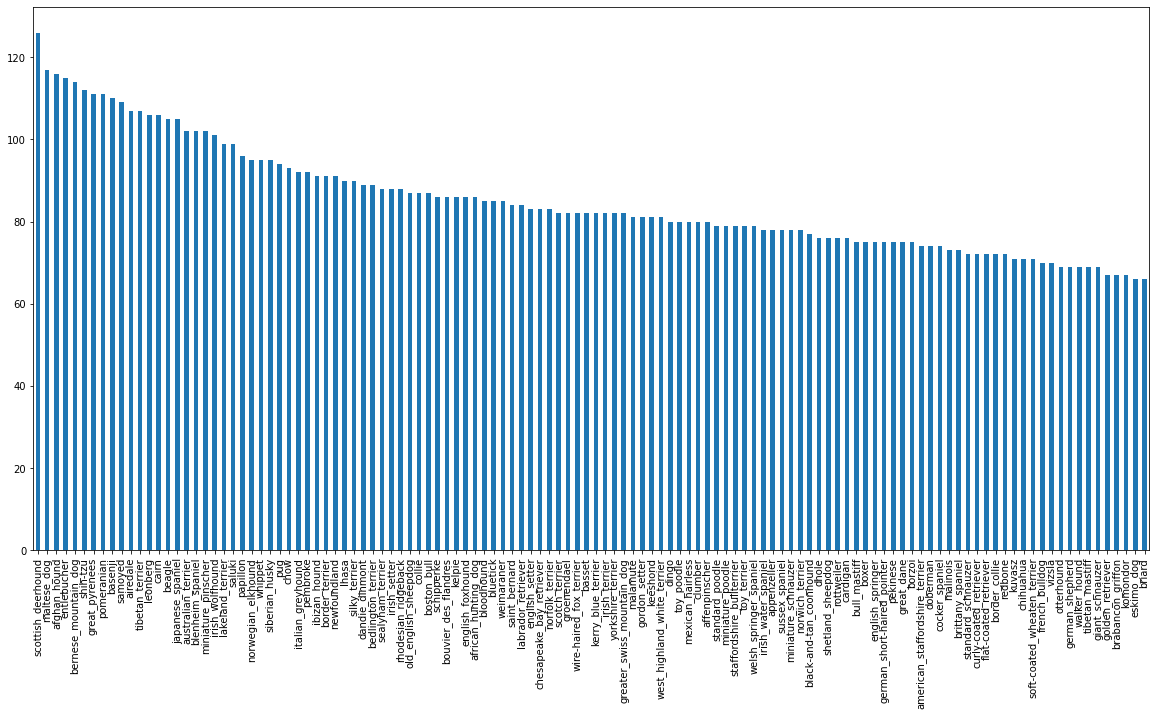

In [7]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [8]:
labels_csv['breed'].value_counts().mean(), labels_csv['breed'].value_counts().median()

(85.18333333333334, 82.0)

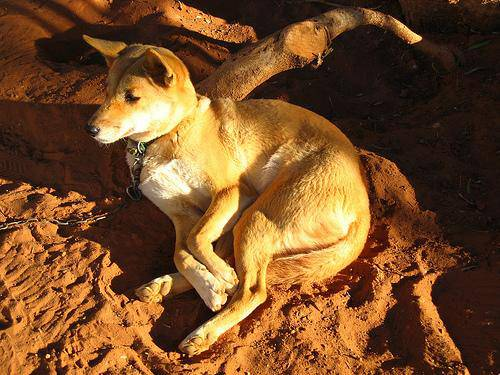

In [9]:
# Checks an uploaded image
Image('drive/MyDrive/ML-Dog-Breed-Identification/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

In [10]:
# Generate list of image file pathnames
filenames = [f'drive/MyDrive/ML-Dog-Breed-Identification/data/train/{fname}.jpg' for fname in labels_csv['id']]
filenames[:5]

['drive/MyDrive/ML-Dog-Breed-Identification/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ML-Dog-Breed-Identification/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ML-Dog-Breed-Identification/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ML-Dog-Breed-Identification/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ML-Dog-Breed-Identification/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [11]:
# Check number of files uploaded
print(f"Number of training images {len(os.listdir('drive/MyDrive/ML-Dog-Breed-Identification/data/train/'))}"
      f", number of testing images {len(os.listdir('drive/MyDrive/ML-Dog-Breed-Identification/data/test/'))}")

Number of training images 10222, number of testing images 10357


In [12]:
print(len(labels_csv))

10222


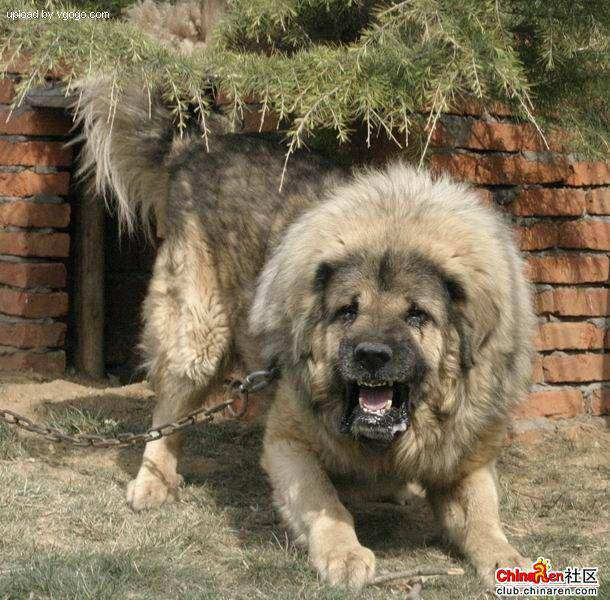

In [13]:
# Check image from filenames
Image(filenames[9000])

In [14]:
labels_csv['breed'][9000]

'tibetan_mastiff'

In [15]:
# Create labels and check counts
labels = np.array(labels_csv['breed'])
labels, len(labels), len(filenames)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222,
 10222)

In [16]:
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [17]:
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

### Create a validation set


In [18]:
# Setup x and y variables
x = filenames
y = boolean_labels

Run experiments with a subset of 1000 images

In [19]:
NUM_IMAGES = 1000 #@param {type: 'slider', min: 1000, max: 10000, step: 1000}

In [20]:
# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [21]:
x_train[:5], y_train[:2]

(['drive/MyDrive/ML-Dog-Breed-Identification/data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/ML-Dog-Breed-Identification/data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/ML-Dog-Breed-Identification/data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/ML-Dog-Breed-Identification/data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/ML-Dog-Breed-Identification/data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, Fals

## Preprocessing Images into Tensors

Steps:
1. Select image filepath
2. Read file with TF and save to variable `image`
3. Turn jpeg `image` into tensor
4. Normalize colors from 0-255 to 0-1
5. Resize `image`
6. Return final `image`


In [22]:
# Set image size
IMG_SIZE = 224

# Function to pre-process images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Convert the specified image into a tensor
  """
  # Read file, create tensor(RGB),normalize colors, and resize
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image
                          

## Create Batches

In [23]:
# Process image and label for batch
def get_image_label(image_path, label):
  """
  Process the image and return the image and label
  """
  image = process_image(image_path)
  return image, label

# Create data batches
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, 
                        test_data=False):
  """
  Create batch of data
  Shuffles if training data 
  """
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) 
    data = data.shuffle(buffer_size = len(x))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  return data_batch

In [24]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

In [25]:
# Check attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [26]:
# Check data batches

# View images in batch
def show_images(images, labels):
  """
  Display images and labels from data batch
  """
  plt.figure(figsize=(10,15))
  for i in range(32):
    ax = plt.subplot(8, 4, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

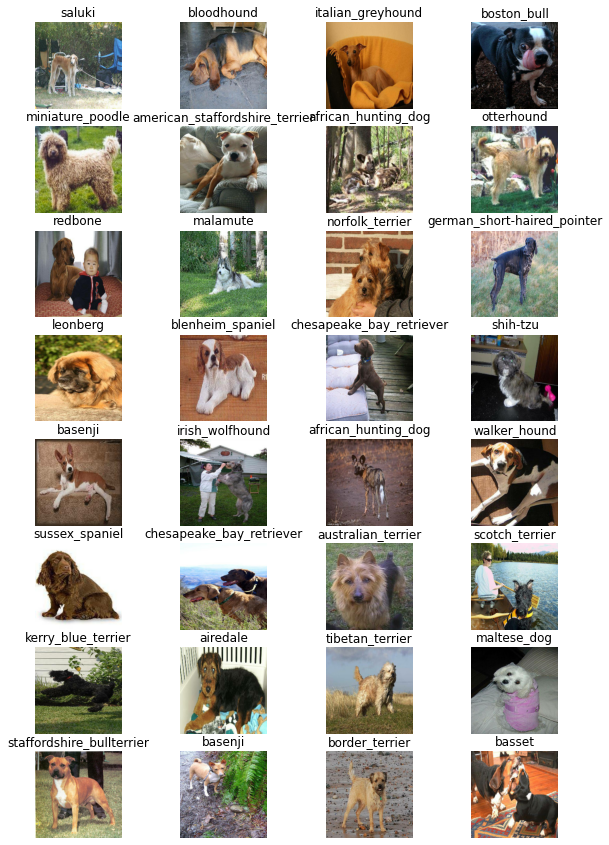

In [27]:
# Show images from training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

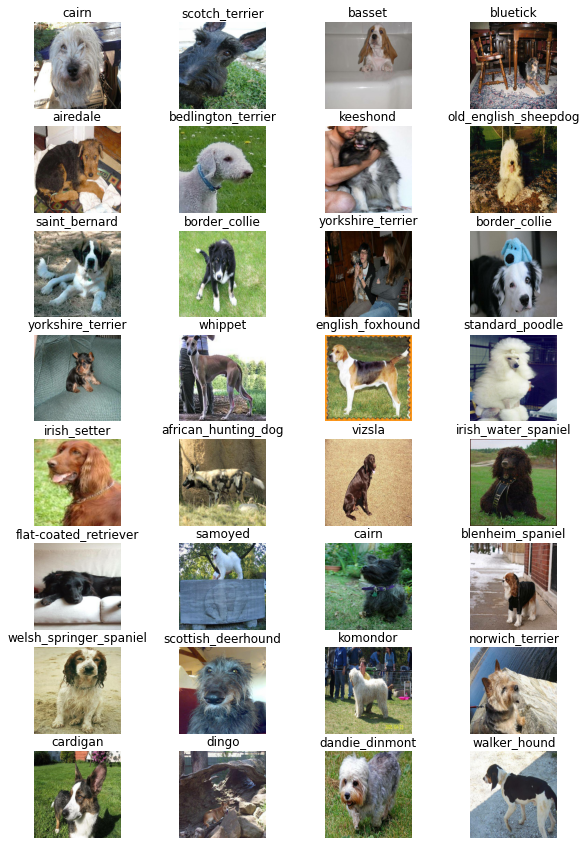

In [28]:
# Show images from validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_images(val_images, val_labels)

## 5. Baseline Modeling

Select a pretrained model from TensorFlow Hub to utilize transfer learning.

The <a href="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4">mobilenet_v2_130_224</a> model takes images of size (224,224) as input, and has been trained in the domain of image classification.

### Build the Model

Define the following for the model:
1. The input shape of the model
2. The output shape of the model
3. The location (URL) of the pretrained model

In [29]:
# Input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Output shape
OUTPUT_SHAPE = len(unique_breeds)

# Select the model from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

In [30]:
from tensorflow._api.v2.config import optimizer
# Build a model using Keras
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, 
                 model_url=MODEL_URL):
  # Setup model
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation='softmax')])
  # Compile model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  # Build model
  model.build(INPUT_SHAPE)
  return model

In [31]:
# Create a model and review its details
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create Callbacks

Create two callbacks:
1. TensorBoard callback to track model progress
2. Early stopping callback to prevent model from overfitting 

### TensorBoard Callback

Save logs to a directory by passing models `fit()` function

In [32]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [33]:
def tensorboard_callback():
  """
  The function builds a tensorboard callback
  """
  logdir = os.path.join("drive/MyDrive/ML-Dog-Breed-Identification/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


### Early Stopping Callback

Prevent model overfitting when evaluation metric stops improving

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)


## Train Model

Check model using a subset of the data

Model workflow:

* Create model
* Set up TensorBoard Callback
* Fit model
* Return model


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [36]:
print("GPU", 'available' if tf.config.list_physical_devices("GPU") else 'not available')

GPU available
